# Домашняя работа

- Сделать обертку (ядро) для имеющей модели
    - Только ядро, сервис с расчетом признаков делать не нужно
    - Реализовать калькулятор - подбор сумм
- Используя обертку насчитать пробу для валидационной выборки
    - Результат prob'ы должен совпасть с использованием интерфейса модели на прямую (predict_proba())
- Придумать логику одобрения суммы:
    - Минизировать сумму, которую не вернули
    - Максимизировать прибыль - максимизировать сумму, которую вернули

- Требования
    - МР в репозиторий с кодом ядра
    - Ноутбук с использованием ядра для насчета proba (также в МРе)
    - Код должен быть воспроизводимым
        - Приложить pickle с моделью
        - Приложить датафрейм с признаками (гит, гугл диск)
    - Объяснение логики одобрения сумм (желательно с цифрами)
    - Срок - до 25.04

Чтож, у нас есть определённое задание, приступим к его выполнению, для начала загрузим нашу выборку и посмотрим на неё


# Для начала загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


: 

Загрузим наш предобработанный датасет полученный из скрипта по генерации признаков с добавлением изначальных признаков из БД

In [2]:
df = pd.read_csv(r'C:\Users\Denis\credit_scoring\src\app\modelling\data_features\features_application_train_test.csv')

In [14]:
df['days_last_phone_change']

0        -1134.0
1         -828.0
2         -815.0
3         -617.0
4        -1106.0
           ...  
356248    -684.0
356249       0.0
356250    -838.0
356251   -2308.0
356252    -327.0
Name: days_last_phone_change, Length: 356253, dtype: float64

In [ ]:


flag_recent_phone_change = (df['days_last_phone_change'] > -30)
flag_recent_registration = (df['days_registration'] > -30)

df['fraud_flag_basic'] = flag_recent_phone_change | flag_recent_registration

flag_last_job = (df['last_job_duration_over_age'] < 0.1)
df['fraud_flag'] = df['fraud_flag_basic'] & flag_last_job
df['fraud_flag'] = df['fraud_flag'].astype(int)

flag_goods_credit_ratio = df['goods_credit_ratio'] > 1



goods_credit_ratio
0    263198
1       236
Name: count, dtype: int64

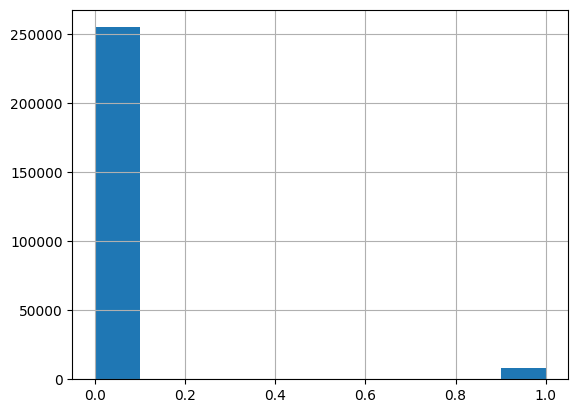

In [106]:
#df['credit_vs_income_ratio'].hist()
flag_high_credit_vs_income = df['credit_vs_income_ratio'] > 10
flag_high_credit_vs_income.astype(int).hist()
df['fraud_flag_2'] = flag_high_credit_vs_income.astype(int)

<Axes: >

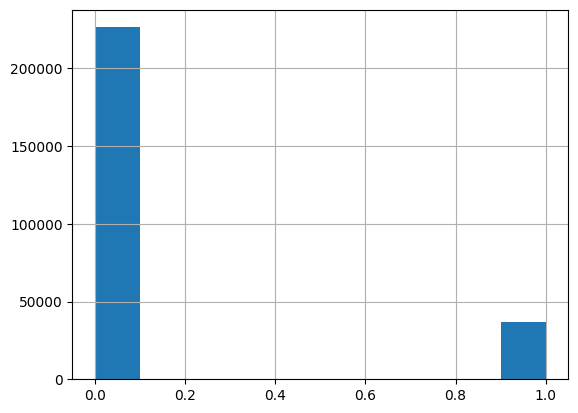

In [87]:
df['fraud_flag'] = df['fraud_flag'].astype(int)
df['fraud_flag'].hist()

Посмотрим на размер выборки

In [107]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
df = df.dropna()
y_true = df['target']   # Реальная метка 1 - fraud, 0 - good
y_pred = df['fraud_flag_2'].astype(int)

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
fpr = fp / (fp + tn)

print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, FPR: {fpr:.3f}")

Precision: 0.061, Recall: 0.025, FPR: 0.032


In [50]:
df.shape

(356253, 59)

Выберем признаки, которые по предыдущим исследованиям, были самые важные

In [3]:
col = ['document_sum', 'year_birth', 'weighted_score', 'credit_vs_income_ratio', 'predicted_rate_interest_primary',
       'annuity_credit_ratio', 'pop_rating_product', 'last_job_duration_over_age', 'name_contract_type',
       'days_last_phone_change','days_registration', 'goods_credit_ratio', 'target']

отфильтруем выборку

In [4]:
df = df[col]

In [5]:
df

,document_sum,year_birth,weighted_score,credit_vs_income_ratio,predicted_rate_interest_primary,annuity_credit_ratio,pop_rating_product,last_job_duration_over_age,name_contract_type,days_last_phone_change,days_registration,goods_credit_ratio,target
0,1,25,0.412429,2.007889,0.200247,0.060749,0.037602,0.067329,Cash loans,-1134.0,-3648,0.863262,1.0
1,1,45,0.762923,4.790750,0.104822,0.027598,0.003541,0.070862,Cash loans,-828.0,-1186,0.873211,0.0
2,0,52,1.141838,2.000000,0.133500,0.050000,0.020064,0.011814,Revolving loans,-815.0,-4260,1.000000,0.0
3,1,52,0.649222,2.316167,0.146057,0.094941,0.016038,0.159905,Cash loans,-617.0,-9833,0.949845,0.0
4,1,54,0.322133,4.222222,0.105411,0.042623,0.057326,0.152418,Cash loans,-1106.0,-4311,1.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
356248,1,54,1.164701,3.395556,0.106413,0.042354,0.006126,0.258838,Cash loans,-684.0,-9094,0.654450,NaN
356249,1,30,0.683312,3.951829,0.120486,0.051267,0.071584,0.102718,Cash loans,0.0,-3015,0.795292,NaN
356250,1,43,1.194098,1.555556,0.351071,0.105414,0.052784,0.190742,Cash loans,-838.0,-2681,1.000000,NaN
356251,1,38,1.093952,2.000000,-0.008446,0.055840,0.037700,0.195518,Cash loans,-2308.0,-1461,1.000000,NaN


Разделим её на тренировачную выборку, валидационную и тестовую

In [5]:
X = df[df['target'].notna()].drop('target', axis=1)
y = df[df['target'].notna()]['target']
test = df[df['target'].isna()]

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

Инициализируем модель

In [7]:
model = CatBoostClassifier(iterations=1000, random_seed=42, loss_function='Logloss', eval_metric='AUC', thread_count=2)

У нас имеется категориальный признак, выделим его и соберём pool для обучения и валидации модели 

In [8]:
cat_features = ['name_contract_type']

In [9]:
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=cat_features)

Обучаем модельку

In [10]:
model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

Learning rate set to 0.11944
0:	test: 0.6671177	best: 0.6671177 (0)	total: 389ms	remaining: 6m 29s
1:	test: 0.6896296	best: 0.6896296 (1)	total: 783ms	remaining: 6m 30s
2:	test: 0.7034956	best: 0.7034956 (2)	total: 980ms	remaining: 5m 25s
3:	test: 0.7063892	best: 0.7063892 (3)	total: 1.17s	remaining: 4m 52s
4:	test: 0.7057040	best: 0.7063892 (3)	total: 1.36s	remaining: 4m 30s
5:	test: 0.7114758	best: 0.7114758 (5)	total: 1.54s	remaining: 4m 15s
6:	test: 0.7137192	best: 0.7137192 (6)	total: 1.7s	remaining: 4m 1s
7:	test: 0.7145352	best: 0.7145352 (7)	total: 1.9s	remaining: 3m 56s
8:	test: 0.7160743	best: 0.7160743 (8)	total: 2.1s	remaining: 3m 51s
9:	test: 0.7180478	best: 0.7180478 (9)	total: 2.29s	remaining: 3m 47s
10:	test: 0.7183045	best: 0.7183045 (10)	total: 2.46s	remaining: 3m 41s
11:	test: 0.7181184	best: 0.7183045 (10)	total: 2.66s	remaining: 3m 39s
12:	test: 0.7186977	best: 0.7186977 (12)	total: 2.86s	remaining: 3m 37s
13:	test: 0.7193016	best: 0.7193016 (13)	total: 3.06s	remai

Хорошо, сохраним модель

In [13]:
X_train.columns

Index(['document_sum', 'year_birth', 'weighted_score',
       'credit_vs_income_ratio', 'predicted_rate_interest_primary',
       'annuity_credit_ratio', 'pop_rating_product',
       'last_job_duration_over_age', 'name_contract_type',
       'days_last_phone_change', 'days_registration', 'goods_credit_ratio'],
      dtype='object')

In [11]:
model.save_model("catboost_model.cbm")

для тестовой выборки сделаем предсказание вероятности дефолта

In [59]:
test = test.copy()
test['PROBA'] = model.predict_proba(test)[:, 1]

test['QUANTILE'] = pd.qcut(
    test['PROBA'],
    q=10,
)
test['QUANTILE_NUMBER'] = pd.qcut(
    test['PROBA'],
    q=10,
    labels=np.arange(10),
)

Тоже сделаем для валидационной выборки

In [60]:
X_valid = X_valid.copy()
X_valid['PROBA'] = model.predict_proba(X_valid)[:, 1]

X_valid['QUANTILE'] = pd.qcut(
    X_valid['PROBA'],
    q=10,
)
X_valid['QUANTILE_NUMBER'] = pd.qcut(
    X_valid['PROBA'],
    q=10,
    labels=np.arange(10),
)

Посмотрим на распределение признаков на тесте

In [61]:
test = test.reset_index()

In [62]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
index,48744.0,331844.861316,14456.054578,1.102400e+04,319694.750000,331880.500000,344066.250000,356252.000000
document_sum,48744.0,0.984675,0.122843,0.000000e+00,1.000000,1.000000,1.000000,1.000000
year_birth,48744.0,43.494481,11.845391,2.000000e+01,34.000000,43.000000,53.000000,68.000000
weighted_score,48744.0,0.979957,0.330383,0.000000e+00,0.748914,1.000368,1.221985,1.824068
credit_vs_income_ratio,48744.0,3.167544,2.137173,9.250000e-02,1.695695,2.666143,4.029600,30.445000
predicted_rate_interest_primary,48744.0,0.222106,0.185977,-7.016612e-02,0.110988,0.182773,0.292745,1.646809
annuity_credit_ratio,48744.0,0.066591,0.024598,5.555556e-07,0.048525,0.061431,0.079442,0.124430
pop_rating_product,48744.0,0.039080,0.019657,5.060000e-04,0.020064,0.038202,0.054627,0.072508
last_job_duration_over_age,48744.0,0.132632,0.135579,3.969041e-05,0.022466,0.094992,0.199510,0.721157
target,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
sort_table = test.groupby([
    'QUANTILE_NUMBER',
]).agg(
    count=pd.NamedAgg(column='index', aggfunc='count'),
    target=pd.NamedAgg(column='PROBA', aggfunc='mean'),
    credit_vs_income_ratio=pd.NamedAgg(column='credit_vs_income_ratio', aggfunc='mean'),
    mean_weighted_score=pd.NamedAgg(column='weighted_score', aggfunc='mean'),
    document_sum=pd.NamedAgg(column='document_sum', aggfunc='mean'),
    years_birth=pd.NamedAgg(column='year_birth', aggfunc='mean'),
    predicted_rate_interest_primary=pd.NamedAgg(column='predicted_rate_interest_primary', aggfunc='median'),
    mean_annuity_credit_ratio=pd.NamedAgg(column='annuity_credit_ratio', aggfunc='mean'),
    pop_rating_product=pd.NamedAgg(column='pop_rating_product', aggfunc='mean'),
    last_job_duration_over_age=pd.NamedAgg(column='last_job_duration_over_age', aggfunc='median'),
    name_contract_type=pd.NamedAgg(column='name_contract_type', aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))

(
    sort_table
    .style
    .format('{:,.2f}', subset=['credit_vs_income_ratio', 'predicted_rate_interest_primary'])
    .format('{:.0f} years', subset=['years_birth'])
    .background_gradient(axis=0, vmin=0, vmax=0.22, gmap=sort_table['target'], cmap="coolwarm")
)

C:\Users\Denis\AppData\Local\Temp\ipykernel_5152\1234858873.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sort_table = test.groupby([


,count,target,credit_vs_income_ratio,mean_weighted_score,document_sum,years_birth,predicted_rate_interest_primary,mean_annuity_credit_ratio,pop_rating_product,last_job_duration_over_age,name_contract_type
QUANTILE_NUMBER,,,,,,,,,,,
0,4875,0.012213,2.53,1.396573,0.965949,49 years,0.19,0.078899,0.040147,0.158377,Cash loans
1,4874,0.021897,3.24,1.271708,0.980509,48 years,0.17,0.065565,0.039969,0.113263,Cash loans
2,4874,0.030074,3.49,1.181335,0.985433,47 years,0.17,0.062258,0.039442,0.097276,Cash loans
3,4875,0.039284,3.37,1.093641,0.981128,46 years,0.18,0.063296,0.039404,0.090288,Cash loans
4,4874,0.050414,3.27,1.017080,0.982561,45 years,0.18,0.063379,0.039173,0.093970,Cash loans
5,4874,0.064369,3.27,0.946538,0.983176,43 years,0.18,0.063035,0.038926,0.096589,Cash loans
6,4875,0.081985,3.27,0.873628,0.987692,42 years,0.18,0.064296,0.038995,0.095564,Cash loans
7,4874,0.107302,3.13,0.791754,0.989331,40 years,0.19,0.065549,0.038570,0.096980,Cash loans
8,4874,0.144635,3.09,0.701279,0.994460,38 years,0.19,0.067169,0.038201,0.087173,Cash loans


## Вывод по таблице:

### Вероятность дефолта (target):


#### Вероятность дефолта увеличивается с ростом номера квантиля. Например:

- В 0-м квантиле вероятность дефолта составляет 0.011991.

- В 9-м квантиле вероятность дефолта возрастает до 0.233724.

Это ожидаемо, так как квантильные группы формируются на основе вероятности дефолта.

### Отношение кредита к доходу (credit_vs_income_ratio):


- В среднем, отношение кредита к доходу уменьшается с ростом номера квантиля:

- В 0-м квантиле оно составляет 2.55.

- В 9-м квантиле оно снижается до 2.99.

Это может указывать на то, что клиенты с более высоким риском дефолта берут меньшие кредиты относительно своего дохода.

### Средний взвешенный скоринг (mean_weighted_score):


#### Значение скоринга уменьшается с ростом номера квантиля:

- В 0-м квантиле оно составляет 1.397090.

- В 9-м квантиле оно снижается до 0.520446.

Это подтверждает, что клиенты с более высоким риском дефолта имеют более низкий скоринг.

### Возраст клиентов (years_birth):


#### Средний возраст клиентов уменьшается с ростом номера квантиля:


- В 0-м квантиле средний возраст составляет 48 лет.

- В 9-м квантиле он снижается до 36 лет.

Молодые клиенты, как правило, имеют более высокий риск дефолта.

### Популярность продукта (pop_rating_product):


 Значение популярности продукта остаётся примерно стабильным во всех квантилях, колеблясь в диапазоне 0.038–0.039.

Это указывает на то, что популярность продукта не сильно влияет на вероятность дефолта.

### Продолжительность последней работы относительно возраста (last_job_duration_over_age):


Этот показатель также уменьшается с ростом номера квантиля:


- В 0-м квантиле он составляет 0.158323.

- В 9-м квантиле он снижается до 0.075390.

Это может указывать на то, что клиенты с более стабильной работой имеют меньший риск дефолта.


### Общий вывод:

Клиенты с более низким риском дефолта (нижние квантили) характеризуются:

Более высоким возрастом.

Более низким отношением кредита к доходу.

Более высоким скорингом.

Более стабильной работой.

Клиенты с более высоким риском дефолта (верхние квантили) имеют противоположные характеристики:
Моложе.

Берут кредиты с более высоким отношением к доходу.

Имеют более низкий скоринг и менее стабильную работу.

In [63]:
X_valid = X_valid.reset_index()
sort_table = X_valid.groupby([
    'QUANTILE_NUMBER',
]).agg(
    count_target=pd.NamedAgg(column='target', aggfunc=lambda x: (x == 1).sum()),
    count=pd.NamedAgg(column='index', aggfunc='count'),
    target=pd.NamedAgg(column='PROBA', aggfunc='mean'),
    credit_vs_income_ratio=pd.NamedAgg(column='credit_vs_income_ratio', aggfunc='mean'),
    mean_weighted_score=pd.NamedAgg(column='weighted_score', aggfunc='mean'),
    document_sum=pd.NamedAgg(column='document_sum', aggfunc='mean'),
    years_birth=pd.NamedAgg(column='year_birth', aggfunc='mean'),
    predicted_rate_interest_primary=pd.NamedAgg(column='predicted_rate_interest_primary', aggfunc='median'),
    mean_annuity_credit_ratio=pd.NamedAgg(column='annuity_credit_ratio', aggfunc='mean'),
    pop_rating_product=pd.NamedAgg(column='pop_rating_product', aggfunc='mean'),
    last_job_duration_over_age=pd.NamedAgg(column='last_job_duration_over_age', aggfunc='median'),
    name_contract_type=pd.NamedAgg(column='name_contract_type', aggfunc=lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan))

(
    sort_table
    .style
    .format('{:,.2f}', subset=['credit_vs_income_ratio', 'predicted_rate_interest_primary'])
    .format('{:.0f} years', subset=['years_birth'])
    .background_gradient(axis=0, vmin=0, vmax=0.22, gmap=sort_table['target'], cmap="coolwarm")
)

C:\Users\Denis\AppData\Local\Temp\ipykernel_5152\1921282156.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sort_table = X_valid.groupby([


KeyError: "Column(s) ['target'] do not exist"

### Сравнение с тестовой выборкой:
- Вероятность дефолта: Валидационная выборка показывает схожую тенденцию роста вероятности дефолта с увеличением квантиля.
- Возраст: Средний возраст клиентов в валидационной выборке немного ниже, чем в тестовой.
- Отношение кредита к доходу: В валидационной выборке это отношение выше, чем в тестовой, что может указывать на различия в выборках.
- Скоринг: Значения скоринга в валидационной выборке немного выше, чем в тестовой.
### Общий вывод:
Валидационная выборка подтверждает основные закономерности, выявленные на тестовой выборке:
- Клиенты с более низким риском дефолта (нижние квантили) характеризуются более высоким возрастом, более низким отношением кредита к доходу, более высоким скорингом и более стабильной работой.
- Клиенты с более высоким риском дефолта (верхние квантили) имеют противоположные характеристики: моложе, с более высоким отношением кредита к доходу, более низким скорингом и менее стабильной работой.

```
Так как мы создаём скрипты параллельно исследованиям создадим класс калькулятор который будет расчитывать сумму которую одобряет модель 

Причины разграничений в логике calc_amount:
Учет вероятности дефолта (proba):

Почему: Вероятность дефолта — ключевой показатель риска клиента. Чем выше вероятность, тем выше риск невозврата кредита.
Аргументация:
При низкой вероятности дефолта (< 0.02) клиент считается максимально надёжным, поэтому ему можно одобрить максимальную сумму.
При увеличении вероятности дефолта (< 0.05, < 0.10, < 0.15) сумма уменьшается, чтобы минимизировать возможные убытки.
Отношение кредита к доходу (credit_vs_income_ratio):

Почему: Это показатель платёжеспособности клиента. Чем выше отношение кредита к доходу, тем больше вероятность, что клиент не сможет обслуживать долг.
Аргументация:
Для клиентов с низким отношением (< 3.5, < 4.0, < 4.5) риск дефолта ниже, поэтому им можно одобрить более крупные суммы.
Если отношение превышает указанные пороги, это сигнализирует о повышенном финансовом напряжении, что ограничивает одобренную сумму.
Возраст клиента (year_birth):

Почему: Возраст клиента влияет на его финансовую стабильность и опыт управления долгами.
Аргументация:
Более старшие клиенты (> 45, > 40, > 36) обычно имеют более стабильный доход и опыт, что снижает риск дефолта.
Молодые клиенты (< 36) чаще имеют нестабильный доход или недостаточный опыт, что увеличивает риск, поэтому им одобряются меньшие суммы.
Градация сумм:

Почему: Градация сумм позволяет банку управлять рисками и максимизировать прибыль.
Аргументация:
Максимальная сумма (500,000) доступна только для клиентов с минимальным риском.
Сумма уменьшается пропорционально увеличению риска, чтобы минимизировать возможные убытки.
Минимальная сумма (100,000):

Почему: Даже для клиентов с высоким риском банк может одобрить минимальную сумму, чтобы сохранить клиента и получить потенциальную прибыль.
Аргументация:
Это позволяет банку оставаться конкурентоспособным, предоставляя кредит даже клиентам с высоким риском, но в ограниченном размере.
Общий вывод:
Логика разграничений в методе calc_amount основана на балансе между риском и доходностью. Она учитывает ключевые показатели риска (вероятность дефолта, платёжеспособность, возраст) и позволяет банку минимизировать убытки, одновременно предоставляя клиентам доступ к кредитам.

Общий вывод:
Логика разграничений в методе calc_amount основана на балансе между риском и доходностью. Она учитывает ключевые показатели риска (вероятность дефолта, платёжеспособность, возраст) и позволяет банку минимизировать убытки, одновременно предоставляя клиентам доступ к кредитам.
```

Смоделируеи расчёт суммы займа с предпологаемыми условиями на основе анализа ранее 

In [64]:
#from statsmodels.stats.proportion import proportion_confint
data = pd.concat([X_valid, y_valid], axis=1)
data = data[['QUANTILE_NUMBER', 'PROBA', 'credit_vs_income_ratio', 'year_birth']]

results = []

for quantile, group in data.groupby('QUANTILE_NUMBER'):
    for _, row in group.iterrows():
        proba = row['PROBA']
        credit_vs_income_ratio = row['credit_vs_income_ratio']
        year_birth = row['year_birth']
        
        # Логика расчёта суммы
        if proba < 0.02 and credit_vs_income_ratio < 3.5 and year_birth > 45:
            approved_amount = 500_000
        elif proba < 0.05 and credit_vs_income_ratio < 4.0 and year_birth > 40:
            approved_amount = 400_000
        elif proba < 0.10 and credit_vs_income_ratio < 4.5 and year_birth > 36:
            approved_amount = 300_000
        elif proba < 0.15:
            approved_amount = 200_000
        else:
            approved_amount = 100_000
        
        results.append({
            'quantile': quantile,
            'proba': proba,
            'credit_vs_income_ratio': credit_vs_income_ratio,
            'year_birth': year_birth,
            'approved_amount': approved_amount
        })

# Результаты
results_df = pd.DataFrame(results)
print(results_df)

C:\Users\Denis\AppData\Local\Temp\ipykernel_5152\123456503.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for quantile, group in data.groupby('QUANTILE_NUMBER'):


       quantile     proba  credit_vs_income_ratio  year_birth  approved_amount
0             0  0.018234                2.490400        52.0           500000
1             0  0.013048                2.726692        38.0           300000
2             0  0.007010                4.108400        55.0           300000
3             0  0.008470                2.000000        68.0           500000
4             0  0.015684                1.611029        30.0           200000
...         ...       ...                     ...         ...              ...
92248         9  0.301956                6.005667        30.0           100000
92249         9  0.178259                3.633300        51.0           100000
92250         9  0.192587                4.985714        27.0           100000
92251         9  0.323130                5.000000        36.0           100000
92252         9  0.278020                2.380952        26.0           100000

[92253 rows x 5 columns]


Посмотрим более детально на распределение сумм по квантелям

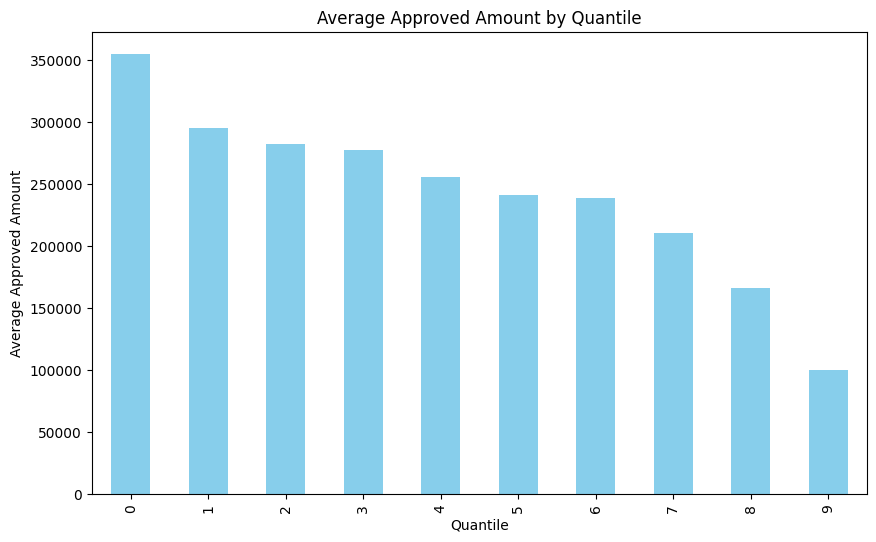

In [65]:
import matplotlib.pyplot as plt
approved_summary = results_df.groupby('quantile')['approved_amount'].mean()

# Построение графика
plt.figure(figsize=(10, 6))
approved_summary.plot(kind='bar', color='skyblue')
plt.xlabel('Quantile')
plt.ylabel('Average Approved Amount')
plt.title('Average Approved Amount by Quantile')
plt.show()

Видим что распределение сум происходит равномерно

## Анализ финансовых метрик
Рассчитаем потенциальные убытки при дефолте ( сумма * вероятность дефолта).
Это поможет оценить, насколько текущие пороги оптимальны с точки зрения прибыли и риска.

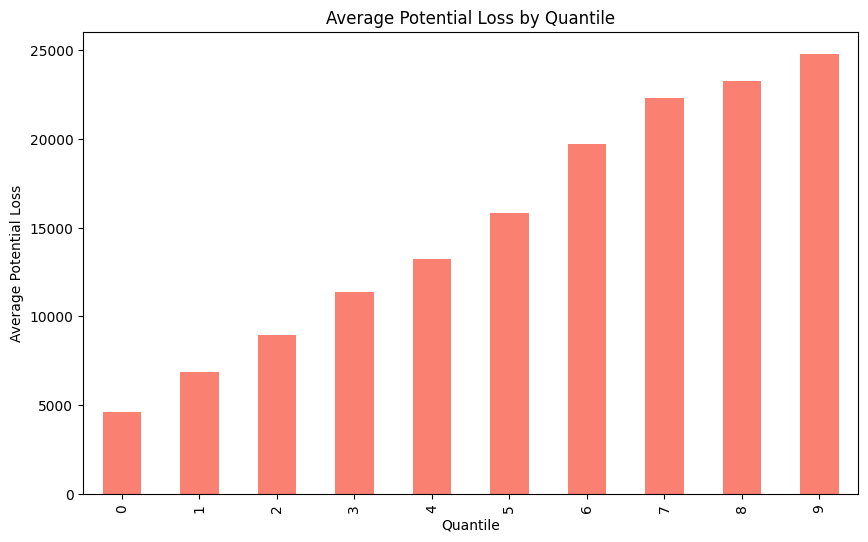

In [66]:
results_df['potential_loss'] = results_df['approved_amount'] * results_df['proba']

# Средние убытки по квантилям
loss_summary = results_df.groupby('quantile')['potential_loss'].mean()

# Построение графика
plt.figure(figsize=(10, 6))
loss_summary.plot(kind='bar', color='salmon')
plt.xlabel('Quantile')
plt.ylabel('Average Potential Loss')
plt.title('Average Potential Loss by Quantile')
plt.show()

видим что для последних квартилей случий невозрата сказывается очень сильно

# ```Я пытался рассчитать условия выдачи максимально выгoдно для бизнеса, рассчитал доверительные интервалы и очень долго всё анализировал и подбирал,пытался даже минимизировать лосс функцию через Optuna выразив потери как убытки, но так как мадель и выборки очень обрезанны, это не предоставлятся возмоджным...``` 

# Импортируем нашу модель

In [37]:
import sys
sys.path.append(r'C:\Users\Denis\credit_scoring\src\app')
from core.model import AdvancedModel
from core.model import Features

In [38]:
del model

Преобразуем первую строку в вид удобный для модели

In [39]:
model = AdvancedModel("catboost_model.cbm")

# Берём строку из DataFrame и превращаем в Features
row = X_valid.iloc[0]
features = Features(
    document_sum=row['document_sum'],
    year_birth=row['year_birth'],
    weighted_score=row['weighted_score'],
    credit_vs_income_ratio=row['credit_vs_income_ratio'],
    predicted_rate_interest_primary=row['predicted_rate_interest_primary'],
    annuity_credit_ratio=row['annuity_credit_ratio'],
    pop_rating_product=row['pop_rating_product'],
    last_job_duration_over_age=row['last_job_duration_over_age'],
    name_contract_type=row['name_contract_type'],
    days_last_phone_change=row['days_last_phone_change'],
    days_registration=row['days_registration'],
    goods_credit_ratio=row['goods_credit_ratio'],
)

# Получаем результат скоринга
result = model.get_scoring_result(features)
print(result.decision, result.amount, result.proba)

ScoringDecision.ACCEPTED 200000 0.04436613931011967


отлично! Посмотрим соответствие новой вероятности и предсказанной ранее

In [40]:
X_valid.iloc[0]

document_sum                                1
year_birth                                 33
weighted_score                       1.164252
credit_vs_income_ratio               0.611892
predicted_rate_interest_primary      0.921691
annuity_credit_ratio                  0.11409
pop_rating_product                    0.01466
last_job_duration_over_age           0.117287
name_contract_type                 Cash loans
days_last_phone_change                -1546.0
days_registration                       -6119
goods_credit_ratio                   0.883392
Name: 127645, dtype: object

Отлично! прогонем всю выборку

In [41]:
# Применяем скоринг AdvancedModel ко всей валидационной выборке X_valid",
def scoring_row(row):
    features = Features(
    document_sum=row['document_sum'],
    year_birth=row['year_birth'],
    weighted_score=row['weighted_score'],
    credit_vs_income_ratio=row['credit_vs_income_ratio'],
    predicted_rate_interest_primary=row['predicted_rate_interest_primary'],
    annuity_credit_ratio=row['annuity_credit_ratio'],
    pop_rating_product=row['pop_rating_product'],
    last_job_duration_over_age=row['last_job_duration_over_age'],
    name_contract_type=row['name_contract_type'],
    days_last_phone_change=row['days_last_phone_change'],
    days_registration=row['days_registration'],
    goods_credit_ratio=row['goods_credit_ratio'],
    )
    result = model.get_scoring_result(features)
    return pd.Series({
            'decision': result.decision,
            'amount': result.amount,
            'proba': result.proba
    })
scoring_results = X_valid.head(1000).apply(scoring_row, axis=1)
X_valid_with_scoring = pd.concat([X_valid.head(100), scoring_results], axis=1)
X_valid_with_scoring.head(20)


,document_sum,year_birth,weighted_score,credit_vs_income_ratio,predicted_rate_interest_primary,annuity_credit_ratio,pop_rating_product,last_job_duration_over_age,name_contract_type,days_last_phone_change,days_registration,goods_credit_ratio,decision,amount,proba
127645,1.0,33.0,1.164252,0.611892,0.921691,0.114090,0.014660,0.117287,Cash loans,-1546.0,-6119.0,0.883392,ScoringDecision.ACCEPTED,200000,0.044366
29982,1.0,57.0,0.170381,3.269755,0.083707,0.054250,0.039378,0.000047,Cash loans,-1960.0,-13886.0,1.000000,ScoringDecision.DECLINED,0,1.000000
20259,1.0,40.0,1.252144,3.707900,0.231866,0.074768,0.019098,0.025919,Cash loans,-706.0,-1172.0,0.943931,ScoringDecision.ACCEPTED,300000,0.062002
297853,1.0,40.0,0.530527,2.227667,0.132864,0.054467,0.037602,0.085206,Cash loans,-214.0,-3570.0,0.748167,ScoringDecision.ACCEPTED,100000,0.265207
83256,1.0,45.0,1.413617,2.010600,0.434652,0.067114,0.071584,0.042765,Cash loans,-2877.0,-9172.0,0.825624,ScoringDecision.ACCEPTED,400000,0.035501
192158,1.0,33.0,0.471697,1.421333,0.673075,0.105675,0.062139,0.014578,Cash loans,-844.0,-511.0,0.938086,ScoringDecision.ACCEPTED,200000,0.080477
228059,1.0,27.0,1.043435,9.000000,0.004794,0.036078,0.057326,0.074941,Cash loans,-1717.0,-2731.0,1.000000,ScoringDecision.ACCEPTED,200000,0.068101
179461,1.0,31.0,1.012339,1.630080,0.611796,0.106105,0.012414,0.188734,Cash loans,-1646.0,-2656.0,0.883392,ScoringDecision.ACCEPTED,200000,0.035055
251208,2.0,28.0,0.761293,2.222222,0.170784,0.045183,0.021932,0.025517,Cash loans,-2.0,-10189.0,1.000000,ScoringDecision.ACCEPTED,200000,0.049365
63133,1.0,43.0,0.181222,5.584000,0.059753,0.032432,0.060738,0.013508,Cash loans,-584.0,-5828.0,0.716332,ScoringDecision.DECLINED,0,0.325706


Отлично! Всё работает!

In [42]:
X_valid_with_scoring['amount'].value_counts()

amount
200000    459
0         206
300000    134
100000     94
400000     82
500000     25
Name: count, dtype: int64